## PFY procedure

In [117]:
scan_file = '/homelocal/rhoms/develop/tmp/clear_data/20190404.dat'
calibration_file = '/homelocal/rhoms/develop/tmp/clear_data/calib_json_046.txt'
start_scan = 318225
nr_scans = 3
user_roi_high = None
user_roi_low = None

In [118]:
import sys
import logging 
import numpy as np
from scipy.interpolate import interp1d
from bl22cleardata.calibration import Calibration
from bl22cleardata.specreader import read_scan
from bl22cleardata.mathfunc import get_mythen_data, normalize
from bl22cleardata.constants import ENERGY, BAD_PIXEL, CEOUT

logging.basicConfig(level=logging.INFO)
calib = Calibration()
calib.load_from_file(calibration_file)

INFO:bl22cleardata.Calibration:Loading calibration from: /homelocal/rhoms/develop/tmp/clear_data/calib_json_046.txt


In [119]:
%matplotlib inline
from matplotlib import pyplot as plt
def plot(data):
    if len(data.shape) == 1:
        plt.plot(data)
    else:
        for i in data:
            plt.plot(i)

### Read scans
Read the scans normalize each one by I0 and concatenate them.

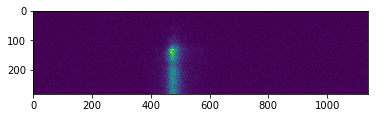

In [120]:
m_data = None
energies = None
ceout = None
for i in range(nr_scans):
    scan_data, scan_snapshot = read_scan(scan_file, start_scan +i )
    m_sub_data = get_mythen_data(scan_data)
    energy_sub_data = scan_data[ENERGY]
    if i == 0:
        m_data = m_sub_data
        energies = energy_sub_data
        ceout = scan_snapshot[CEOUT] 
    else:
       m_data = np.append(m_data, m_sub_data, axis=0)
       energies = np.append(energies, energy_sub_data)
plt.imshow(m_data)

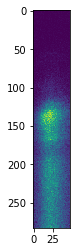

In [121]:
plt.imshow(m_data[:,calib.roi_low:calib.roi_high])

## Calculate PFY
The mythen energy will be fix because the clear is not moving. For that we 
will use the ceout of the first scan. 

1) Calculate the shift on the mythen energy scale according to ceout.

2) Generate two scales:
   * discrete_energy_scale: Use for generated the interpolate function.
   * cont_mythen_energy_scale: Used for the interpolated data.

3) Generate the calibration window normalized (noise, 1). 

4) Normalize mythen data per the calibration window (for i in m_data: 
i/calib_window)

5) Use calculate de calibration ROI in energy scale and compared with the user 
roi, if the user roi is smaller use them.

6) Sum the matrix and generate the pfy plot.

NOTE: We can generalize the process to assume that the ceout will be change 
between the scans. 

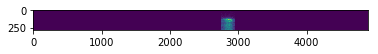

In [122]:
# Calculate the Mythen energy scales: discrete and continuous
p0_e = calib.energy2pixel(ceout).astype(int) [0]
p0_delta = p0_e - calib.p0
min_pixel_scale = 0 + p0_delta
max_pixel_scale = BAD_PIXEL + p0_delta
min_energy_scale = calib.pixel2energy(max_pixel_scale)
max_energy_scale = calib.pixel2energy(min_pixel_scale)
energy_step = int(abs((max_energy_scale - min_energy_scale) 
                      / calib.energy_resolution))
cont_energy_scale = np.linspace(min_energy_scale, max_energy_scale,
                                energy_step)
discrete_energy_scale = calib.pixel2energy(range(min_pixel_scale, 
                                                 max_pixel_scale))

# Calculate the energy roi, lower pixel higher energies
energy_roi_low = calib.pixel2energy(calib.roi_high + p0_delta)
energy_roi_high = calib.pixel2energy(calib.roi_low + p0_delta)

if user_roi_high is not None and user_roi_high < energy_roi_high:
    energy_roi_high = user_roi_high
if user_roi_low is not None and user_roi_low > energy_roi_low:
    energy_roi_low = user_roi_low

idx = np.where(cont_energy_scale > energy_roi_low)[0] 
idx_energy_roi_low = idx.min()
idx = np.where(cont_energy_scale < energy_roi_high)[0]
idx_energy_roi_high = idx.max()

# Normalize the mythen calibration between 1 and noise level
m_calib_norm = normalize(calib.m_calib, scale_min=calib.noise_percent/100)
delta_energy = ceout - calib.e0
calib_energy_scale = calib.m_energy_scale + delta_energy
f_calib = interp1d(calib_energy_scale, m_calib_norm, bounds_error=False, 
                   fill_value=1)

# Interpolation function for the calibration window: 1 inside
# the window and 0 outside
calib_window = np.ones(m_calib_norm.shape[0])
f_calib_window = interp1d(calib_energy_scale, calib_window,
                          bounds_error=False, fill_value=0)

nr_points = m_data.shape[0]
intensity_matrix = np.zeros([nr_points, energy_step])

for idx, m_i_raw in enumerate(m_data):
 
    # Calculate the discrete energy scale for the Mythen RAW data
    # interpolation.
    f_mythen_raw = interp1d(discrete_energy_scale, m_i_raw,
                            bounds_error=False, fill_value=0)
    # Calulate the intensity value Yi:
    # 1) Set to Zero value out of the window by multiplying with
    #    f_calib_window
    # 2) Normalize by the mythen_calibration by dividing per f_calib

    m_i_raw_window = f_mythen_raw(cont_energy_scale) * \
                     f_calib_window(cont_energy_scale)
    Yi = m_i_raw_window / f_calib(cont_energy_scale)
    
    intensity_matrix[idx] = Yi
plt.imshow(intensity_matrix)

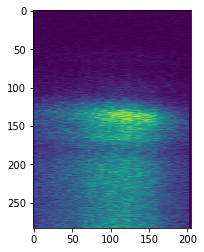

In [123]:
plt.imshow(intensity_matrix[:,idx_energy_roi_low: idx_energy_roi_high])
   

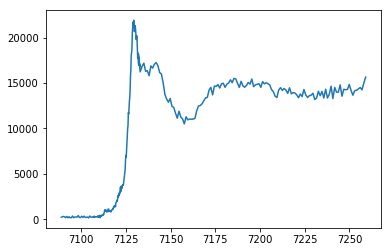

In [124]:
pfy = intensity_matrix[:,idx_energy_roi_low:idx_energy_roi_high].sum(axis=1)
plt.plot(energies, pfy)

